In [89]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import pickle

'''
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.5f}'.format)
'''

"\npd.set_option('display.max_rows', 500)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)\npd.set_option('display.float_format', '{:,.5f}'.format)\n"

In [90]:
fac = pickle.load(open("../data/facilities_wide.pkl", "rb"))
fac=fac.replace(r'^\s*$', np.nan, regex=True)
print(fac.shape)
fac

(307, 55)


,hotel_name_,all_facilities,unlist,facilities_count,in_top_facilities,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,...,hairdryer,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service
0,RedDoorz near East Avenue Medical Center,"[[Toilet paper, Towels, Towels/Sheets (extra f...","[toilet paper, towels, towels/sheets (extra fe...",22,"[toilet paper, towels, toilet, free toiletries...",1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Skylab Guesthouse,"[[Toilet paper, Towels, Additional bathroom, B...","[toilet paper, towels, additional bathroom, bi...",97,"[toilet paper, towels, bidet, slippers, toilet...",1,1,1,0,0,...,1,1,1,0,0,0,0,1,0,1
2,The Excelsior Hotel Las Piñas,"[[Toilet paper, Towels, Bidet, Guest bathroom,...","[toilet paper, towels, bidet, guest bathroom, ...",97,"[toilet paper, towels, bidet, slippers, privat...",1,1,1,1,1,...,1,1,0,1,0,1,1,1,1,0
3,Rothman Hotel,"[[Private Bathroom, Toilet, Free toiletries, S...","[private bathroom, toilet, free toiletries, sh...",38,"[private bathroom, toilet, free toiletries, sh...",1,1,0,1,1,...,0,0,0,0,1,0,0,0,1,1
4,OYO 772 Remedios Apartment,"[[TV], [Daily housekeeping, Concierge], [Fire ...","[tv, daily housekeeping, concierge, fire extin...",11,"[tv, daily housekeeping, concierge, fire extin...",1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,RedDoorz at EDSA Pasay,"[[Toilet paper, Towels, Towels/Sheets (extra f...","[toilet paper, towels, towels/sheets (extra fe...",18,"[toilet paper, towels, private bathroom, toile...",1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
303,Kabayan Hotel Pasay,"[[Toilet paper, Towels, Bidet, Slippers, Priva...","[toilet paper, towels, bidet, slippers, privat...",47,"[toilet paper, towels, bidet, slippers, privat...",1,1,1,1,1,...,0,1,0,0,0,0,1,0,0,0
304,"Crimson Hotel Filinvest City, Manila","[[Themed dinners, Temporary art galleries], [C...","[themed dinners, temporary art galleries, coff...",56,"[bar, restaurant, accessible parking, concierg...",1,1,1,1,0,...,0,0,0,1,1,0,0,0,1,0
305,RedDoorz @ Jardin LRT Tayuman Manila,"[[Toilet paper, Towels, Towels/Sheets (extra f...","[toilet paper, towels, towels/sheets (extra fe...",14,"[toilet paper, towels, private bathroom, toile...",1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)

(76536, 94)


In [92]:
df['facilities_count']

0        22
1        22
2        22
3        22
4        22
         ..
76531    54
76532    54
76533    54
76534    54
76535    54
Name: facilities_count, Length: 76536, dtype: int64

In [93]:
df["review_score"]

0          10 
1         7.0 
2         5.0 
3         6.0 
4         7.0 
         ...  
76531      10 
76532      10 
76533     5.0 
76534     2.9 
76535     7.9 
Name: review_score, Length: 76536, dtype: object

In [94]:
df["review_score"]=df["review_score"].apply(lambda x: float(x.strip()))
df["nights_stayed_"]=df["nights_stayed"].apply(lambda x: int(x.strip().split(" ")[0]))

month_map = {'January':1, 'February':2, 'March':3 , 'April':4, 'May':5, 'June':6,
             'July':7, 'August':8 , 'September':9, 'October':10, 'November':11, 'December':12}

df['date_stayed']=df['month_stayed'].apply(lambda x: dt.datetime(int(x.strip().split(" ")[1]),month_map[x.strip().split(" ")[0]],1))
df['month_name'] = df['month_stayed'].apply(lambda x: x.strip().split(" ")[0])
df['month'] = df['month_name'].map(month_map)
df['year'] = df['month_stayed'].apply(lambda x: x.strip().split(" ")[1])


df['date_reviewed_']=df['date_reviewed'].apply(lambda x: dt.datetime(int(x.strip().split(" ")[1]),month_map[x.strip().split(" ")[0]],1))
df['month_name_reviewed'] = df['date_reviewed'].apply(lambda x: x.strip().split(" ")[0])
df['month_reviewed'] = df['month_name_reviewed'].map(month_map)
df['year_reviewed'] = df['date_reviewed'].apply(lambda x: x.strip().split(" ")[1])



In [95]:
def plot_bar_sp(df,c,title,dmap="default",orient='x',clr='#6cc8ba',hue=False, \
                 time_series=False, month_data=False,week_data=False,pod_data=False, long_dates=False,ax=None,limited=False):
    #F25278
    ax = ax or plt.gca()
    
    #data_df=df
    data_df = df[[c]]
    
    
    if hue!=False:  
        data_df = df[[c]+[hue]]
        #print(data_df)
    
    
       
    
    if dmap=="default":
        data_df['Class'] = data_df[c]
    
    else:
        data_df['Class'] = data_df[c].map(dmap)
    #print(data_df)
    
    #Order
    if time_series==False:
        o=data_df['Class'].value_counts().index
        #print(o)
    
    #Time- Series ORder
    else:
        o=data_df['Class'].value_counts().index.sort_values(ascending=True)
        
        
        if month_data==True:
            o=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct", "Nov", "Dec"]
            if long_dates==True:
                o=["January","February","March","April","May","June","July","August","September","October", "November", "December"]  
        if week_data==True:
            o=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"] 
            if long_dates==True:
                o=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"] 
                
        if pod_data==True:
            o=["early morning","breakfast","lunch","afternoon","dinner"] 
                #Would change this to off Hours
        
    if limited!=False:
        o=o[:limited]
        #print(o)
   
    #data_df["Class"]=data_df["Class"].astype(str)
    #print(data_df)
    #hue
    if hue==False:  
        if orient=='x':
            return sns.countplot(x=data_df['Class'], order=o,ax=ax, color=clr)
            

        else:
            return sns.countplot(y=data_df['Class'],order=o ,ax=ax,color=clr)
        
    if hue!=False:  
        #data_df["Class"]=data_df["Class"].astype(str)
        #l=o[:10]
        data_df["Class"] = pd.Categorical(data_df['Class'], o)
        if orient=='x':
            return sns.histplot(data_df, x="Class", hue="good_review", stat="percent",ax=ax,multiple="layer", shrink=.4,common_norm=False)

        else:
            return sns.histplot(data_df, y="Class", hue="good_review", stat="percent",ax=ax,multiple="dodge", shrink=.2,common_norm=False)

    ax.set_title(title)

In [96]:
#id_cols=['name',"type1","type2"]
traveller_cols=['name','occupant_type','from_country',"room_type_y",'nights_stayed_',
                #'month_stayed',"'date_reviewed',",
                'date_stayed','month','year','month_name',
                'date_reviewed_','month_reviewed','year_reviewed',
                'review_score']

In [97]:
df["good_review"]=np.where(df["review_score"]>=7.5,1,0)
df

,hotel_name_,stars,location,review_rating,description,main_facilities,total_reviews,sub_ratings,sub_ratings_categories,sub_ratings_dict,...,nights_stayed_,date_stayed,month_name,month,year,date_reviewed_,month_name_reviewed,month_reviewed,year_reviewed,good_review
0,RedDoorz near East Avenue Medical Center,2,"90 Matatag Street, Quezon City, 1100 Manila, P...",6.0,RedDoorz near East Avenue Medical Center featu...,"[Non Smoking Rooms, Free WiFi Internet Access ...",88,"[6.9, 6.3, 6.5, 6.5, 7.0, 7.8, 6.3]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '6.9', 'Facilities': '6.3', 'Cleanli...",...,1,2022-01-01,January,1,2022,2022-01-01,January,1,2022,1
1,RedDoorz near East Avenue Medical Center,2,"90 Matatag Street, Quezon City, 1100 Manila, P...",6.0,RedDoorz near East Avenue Medical Center featu...,"[Non Smoking Rooms, Free WiFi Internet Access ...",88,"[6.9, 6.3, 6.5, 6.5, 7.0, 7.8, 6.3]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '6.9', 'Facilities': '6.3', 'Cleanli...",...,2,2022-11-01,November,11,2022,2022-11-01,November,11,2022,0
2,RedDoorz near East Avenue Medical Center,2,"90 Matatag Street, Quezon City, 1100 Manila, P...",6.0,RedDoorz near East Avenue Medical Center featu...,"[Non Smoking Rooms, Free WiFi Internet Access ...",88,"[6.9, 6.3, 6.5, 6.5, 7.0, 7.8, 6.3]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '6.9', 'Facilities': '6.3', 'Cleanli...",...,1,2022-06-01,June,6,2022,2022-06-01,June,6,2022,0
3,RedDoorz near East Avenue Medical Center,2,"90 Matatag Street, Quezon City, 1100 Manila, P...",6.0,RedDoorz near East Avenue Medical Center featu...,"[Non Smoking Rooms, Free WiFi Internet Access ...",88,"[6.9, 6.3, 6.5, 6.5, 7.0, 7.8, 6.3]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '6.9', 'Facilities': '6.3', 'Cleanli...",...,6,2022-05-01,May,5,2022,2022-05-01,May,5,2022,0
4,RedDoorz near East Avenue Medical Center,2,"90 Matatag Street, Quezon City, 1100 Manila, P...",6.0,RedDoorz near East Avenue Medical Center featu...,"[Non Smoking Rooms, Free WiFi Internet Access ...",88,"[6.9, 6.3, 6.5, 6.5, 7.0, 7.8, 6.3]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '6.9', 'Facilities': '6.3', 'Cleanli...",...,1,2022-05-01,May,5,2022,2022-05-01,May,5,2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76531,88 Courtyard Hotel,3,"24 Roxas Boulevard, corner Cuneta Avenue, Pasa...",7.5,You're eligible for a Genius discount at 88 Co...,"[Airport Shuttle, Non Smoking Rooms, Room-serv...",173,"[8.4, 7.4, 7.7, 7.8, 7.5, 8.1, 5.8]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '8.4', 'Facilities': '7.4', 'Cleanli...",...,1,2022-03-01,March,3,2022,2022-03-01,March,3,2022,1
76532,88 Courtyard Hotel,3,"24 Roxas Boulevard, corner Cuneta Avenue, Pasa...",7.5,You're eligible for a Genius discount at 88 Co...,"[Airport Shuttle, Non Smoking Rooms, Room-serv...",173,"[8.4, 7.4, 7.7, 7.8, 7.5, 8.1, 5.8]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '8.4', 'Facilities': '7.4', 'Cleanli...",...,1,2022-03-01,March,3,2022,2022-03-01,March,3,2022,1
76533,88 Courtyard Hotel,3,"24 Roxas Boulevard, corner Cuneta Avenue, Pasa...",7.5,You're eligible for a Genius discount at 88 Co...,"[Airport Shuttle, Non Smoking Rooms, Room-serv...",173,"[8.4, 7.4, 7.7, 7.8, 7.5, 8.1, 5.8]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '8.4', 'Facilities': '7.4', 'Cleanli...",...,2,2019-12-01,December,12,2019,2019-12-01,December,12,2019,0
76534,88 Courtyard Hotel,3,"24 Roxas Boulevard, corner Cuneta Avenue, Pasa...",7.5,You're eligible for a Genius discount at 88 Co...,"[Airport Shuttle, Non Smoking Rooms, Room-serv...",173,"[8.4, 7.4, 7.7, 7.8, 7.5, 8.1, 5.8]","[Staff, Facilities, Cleanliness, Comfort, Valu...","{'Staff': '8.4', 'Facilities': '7.4', 'Cleanli...",...,2,2019-12-01,December,12,2019,2019-12-01,December,12,2019,0


In [98]:
df.columns

Index(['hotel_name_', 'stars', 'location', 'review_rating', 'description',
       'main_facilities', 'total_reviews', 'sub_ratings',
       'sub_ratings_categories', 'sub_ratings_dict',
       ...
       'nights_stayed_', 'date_stayed', 'month_name', 'month', 'year',
       'date_reviewed_', 'month_name_reviewed', 'month_reviewed',
       'year_reviewed', 'good_review'],
      dtype='object', length=104)

In [99]:
df.groupby("good_review").sum()

,stars,cheapest_price,facilities_count,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,smoke alarms,toilet,...,nearest_ocean,nearest_other,number_close,nearest_other_2km,zip_code,latitude,longitude,nights_stayed_,month,month_reviewed
good_review,,,,,,,,,,,,,,,,,,,,,
0,77645,55601200.0,1161628,24937,24065,21168,23315,19522,19773,19012,...,249440.55,24569.24,508453,125339,32920883,365090.365933,3.034527e+06,58652,165551,165551
1,174172,150214958.0,2790919,51310,50261,44702,48445,40675,43759,39145,...,571652.35,51582.10,1043251,267296,66548138,749168.421620,6.227170e+06,110013,339172,339172


good_review    51459
bad_review     25077
Name: type of review, dtype: int64

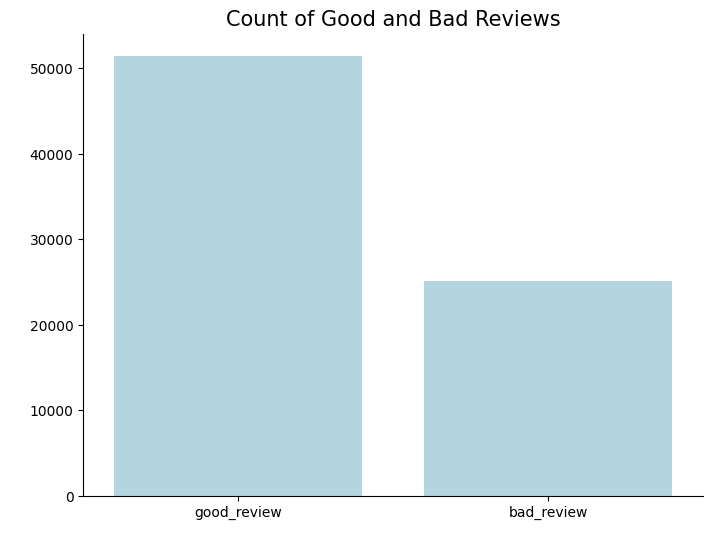

In [100]:
review_map = {0: 'bad_review', 1: 'good_review'}
df['type of review'] = df['good_review'].map(review_map)
color = ['lightblue']

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x=df['type of review'],
              order=df['type of review'].value_counts().index,
              color='lightblue')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.set_title(f'Count of Good and Bad Reviews', size=15, y=1)
display(df['type of review'].value_counts())
plt.show()

In [101]:
from pandas_profiling import ProfileReport

In [102]:
fac_cols = ['hotel_name_', 'stars', 'review_rating', 'total_reviews', 'good_review', 'facilities_count', 
'air conditioning',
 'non-smoking rooms',
 'fire extinguishers',
 'cctv in common areas',
 'private bathroom',
 'smoke alarms',
 'toilet',
 'tv',
 '24-hour security',
 'towels',
 'free toiletries',
 '24-hour front desk',
 'shower',
 'toilet paper',
 'airport shuttle',
 'elevator',
 'linens',
 'security alarm',
 'flat-screen tv',
 'daily housekeeping',
 'cctv outside property',
 'room service',
 'designated smoking area',
 'safe',
 'desk',
 'bidet',
 'smoke-free property',
 'baggage storage',
 'cable channels',
 'telephone',
 'restaurant',
 'key card access',
 'electric kettle',
 'meeting/banquet facilities',
 'laundry',
 'fax/photocopying',
 'upper floors accessible by elevator',
 'family rooms',
 'wake-up service',
 'concierge',
 'hairdryer',
 'slippers',
 'key access',
 'accessible parking',
 'facilities for disabled guests',
 'wardrobe or closet',
 'clothes rack',
 'socket near the bed',
 'bar',
 'ironing service']
df_fac = df[fac_cols]
df_fac

,hotel_name_,stars,review_rating,total_reviews,good_review,facilities_count,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,...,hairdryer,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service
0,RedDoorz near East Avenue Medical Center,2,6.0,88,1,22,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76531,88 Courtyard Hotel,3,7.5,173,1,54,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76532,88 Courtyard Hotel,3,7.5,173,1,54,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76533,88 Courtyard Hotel,3,7.5,173,0,54,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76534,88 Courtyard Hotel,3,7.5,173,0,54,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0


In [104]:
df_fac.groupby("good_review").mean()

,stars,facilities_count,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,smoke alarms,toilet,tv,...,hairdryer,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service
good_review,,,,,,,,,,,,,,,,,,,,,
0,3.096264,46.322447,0.994417,0.959644,0.844120,0.929736,0.778482,0.788491,0.758145,0.720341,...,0.417075,0.435140,0.278861,0.351039,0.454560,0.302668,0.389441,0.357100,0.315070,0.356781
1,3.384675,54.235780,0.997104,0.976719,0.868692,0.941429,0.790435,0.850366,0.760703,0.736450,...,0.511417,0.505898,0.245807,0.462193,0.600886,0.387085,0.497153,0.392837,0.390641,0.425718


<AxesSubplot: xlabel='facilities_count', ylabel='Density'>

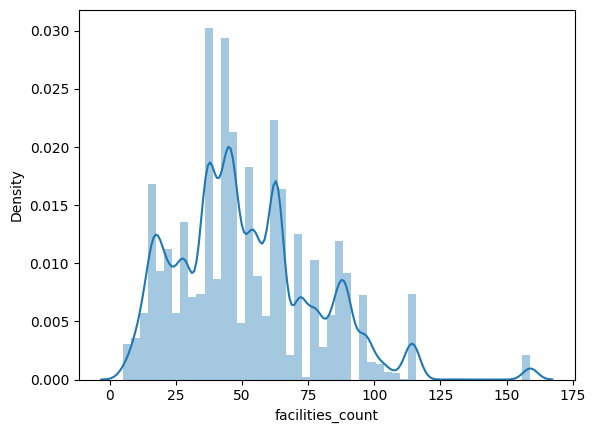

In [105]:
sns.distplot(df_fac['facilities_count'])

In [106]:
df_fac.iloc[:, 6:]

,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,smoke alarms,toilet,tv,24-hour security,towels,...,hairdryer,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service
0,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,1,1,1,0,0,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76531,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76532,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76533,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76534,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0


In [107]:
df_fac['top50_facs'] = df_fac.iloc[:, 6:].sum(axis = 1)

In [108]:
df_fac

,hotel_name_,stars,review_rating,total_reviews,good_review,facilities_count,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,...,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service,top50_facs
0,RedDoorz near East Avenue Medical Center,2,6.0,88,1,22,1,1,1,0,...,0,1,0,0,0,0,0,0,0,18
1,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,1,0,0,0,0,0,0,0,18
2,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,1,0,0,0,0,0,0,0,18
3,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,1,0,0,0,0,0,0,0,18
4,RedDoorz near East Avenue Medical Center,2,6.0,88,0,22,1,1,1,0,...,0,1,0,0,0,0,0,0,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76531,88 Courtyard Hotel,3,7.5,173,1,54,1,1,1,1,...,1,0,1,1,1,1,1,0,0,41
76532,88 Courtyard Hotel,3,7.5,173,1,54,1,1,1,1,...,1,0,1,1,1,1,1,0,0,41
76533,88 Courtyard Hotel,3,7.5,173,0,54,1,1,1,1,...,1,0,1,1,1,1,1,0,0,41
76534,88 Courtyard Hotel,3,7.5,173,0,54,1,1,1,1,...,1,0,1,1,1,1,1,0,0,41


<AxesSubplot: xlabel='top50_facs', ylabel='Density'>

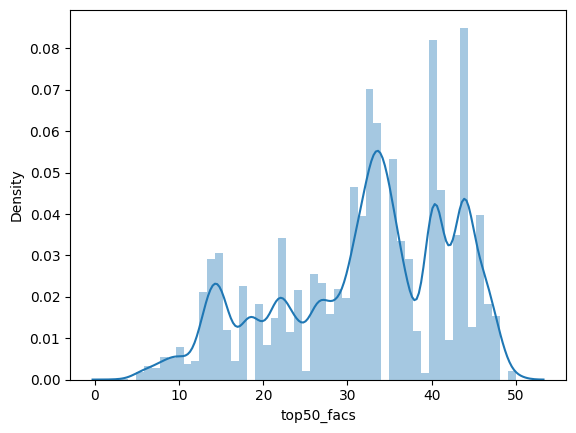

In [109]:
sns.distplot(df_fac['top50_facs'])

In [110]:
df_fac.groupby(["stars", "good_review"]).mean()

facilities_count  air conditioning  non-smoking rooms  \
stars good_review                                                          
1     0                   20.322581          0.993548           1.000000   
      1                   19.981818          0.990909           1.000000   
2     0                   30.953926          0.988843           0.859504   
      1                   32.354233          0.991498           0.887531   
3     0                   41.839859          0.994242           0.991058   
      1                   45.603763          0.996529           0.994932   
4     0                   67.589077          1.000000           0.935306   
      1                   68.859707          1.000000           0.949096   
5     0                   81.602941          1.000000           0.999554   
      1                   83.563555          1.000000           0.999658   

                   fire extinguishers  cctv in common areas  private bathroom  \
stars good_review                                                               
1     0                      1.000000              1.000000          0.554839   
      1                      1.000000              1.000000          0.645455   
2     0                      0.914463              0.915702          0.809917   
      1                      0.870705              0.939603          0.798441   
3     0                      0.787766              0.925959          0.775708   
      1                      0.843470              0.946712          0.816427   
4     0                      0.977243              0.978869          0.934655   
      1                      0.977868              0.982171          0.938645   
5     0                      0.869875              0.912656          0.530303   
      1                      0.847330              0.886696          0.564126   

                   smoke alarms    toilet        tv  24-hour security  ...  \
stars good_review                                                      ...   
1     0                0.432258  0.535484  0.864516          0.432258  ...   
      1                0.472727  0.636364  0.809091          0.472727  ...   
2     0                0.676240  0.707851  0.557025          0.608678  ...   
      1                0.752214  0.661176  0.607510          0.691109  ...   
3     0                0.780450  0.753082  0.789527          0.772456  ...   
      1                0.840346  0.769041  0.809033          0.795876  ...   
4     0                0.978544  0.909948  0.730819          0.960013  ...   
      1                0.982171  0.893028  0.760974          0.973442  ...   
5     0                0.847594  0.707219  0.593137          0.870766  ...   
      1                0.828959  0.676175  0.557280          0.847901  ...   

                   slippers  key access  accessible parking  \
stars good_review                                             
1     0            0.129032    0.296774            0.000000   
      1            0.181818    0.281818            0.000000   
2     0            0.384504    0.549793            0.029339   
      1            0.309245    0.517535            0.048530   
3     0            0.345346    0.242244            0.384162   
      1            0.392071    0.238214            0.497570   
4     0            0.736671    0.124187            0.540962   
      1            0.790606    0.145703            0.520595   
5     0            0.742870    0.146168            0.590909   
      1            0.746577    0.188156            0.564012   

                   facilities for disabled guests  wardrobe or closet  \
stars good_review                                                       
1     0                                  0.000000            0.000000   
      1                                  0.000000            0.000000   
2     0                                  0.137190            0.207231   
      1                                  0.113355            0.303046   
3

In [88]:
df_fac.groupby(["stars"]).mean()

,good_review,facilities_count,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,smoke alarms,toilet,tv,...,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service,top50_facs
stars,,,,,,,,,,,,,,,,,,,,,
1,0.415094,17.135849,0.992453,1.000000,1.000000,1.000000,0.592453,0.449057,0.577358,0.841509,...,0.150943,0.290566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.135849
2,0.538432,23.975586,0.990273,0.874595,0.890902,0.928571,0.803738,0.717147,0.682720,0.584208,...,0.343982,0.532424,0.039672,0.124356,0.258821,0.122830,0.464143,0.158402,0.141045,23.975586
3,0.661173,30.818651,0.995754,0.993619,0.824596,0.939680,0.802630,0.820051,0.763634,0.802424,...,0.376239,0.239580,0.459144,0.505073,0.225349,0.536977,0.369468,0.180913,0.264437,30.818651
4,0.725578,40.607191,1.000000,0.945312,0.977696,0.981265,0.937550,0.981176,0.897672,0.752699,...,0.775805,0.139798,0.526184,0.772683,0.805603,0.635115,0.450709,0.742082,0.787581,40.607191
5,0.796148,36.692769,1.000000,0.999637,0.851926,0.891988,0.557231,0.832758,0.682504,0.564589,...,0.745821,0.179597,0.569495,0.940225,0.540243,0.322220,0.286519,0.921330,0.819949,36.692769


In [177]:
### Star = 1-5
def most_facs_per_star(star):
    colors = ['#bfdeff', '#80bcff', '#0059ba', '#00438c', '#003e82']
    dfs = df_fac[(df_fac['stars'] == star) & (df_fac['good_review'] == 1)]
    total_cols = dfs.shape[0]
    dfs = dfs.set_index('hotel_name_')
    to_drop = ['facilities_count','stars', 'review_rating', 'total_reviews', 'good_review', 'top50_facs']
    dfs_trans = dfs.drop(to_drop, axis=1)
    dfs_trans = dfs_trans.T
    dfs_trans['freq_of_facilities'] = dfs_trans.sum(axis = 1)
    dfs_trans['\% of freq_of_facilities'] = dfs_trans['freq_of_facilities'] / total_cols
    dfs_trans.sort_values(by=['\% of freq_of_facilities'], inplace=True, ascending=True)
    
    
    colors_l = [colors[star-1]] * 20
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(dfs_trans.index[-10:], dfs_trans['\% of freq_of_facilities'].iloc[-10:], color=colors_l)
    ax.set_title(f'Most common facilities in good-reviewed {star}-star hotels')
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
        ax.bar_label(ax.containers[0])
    plt.show()

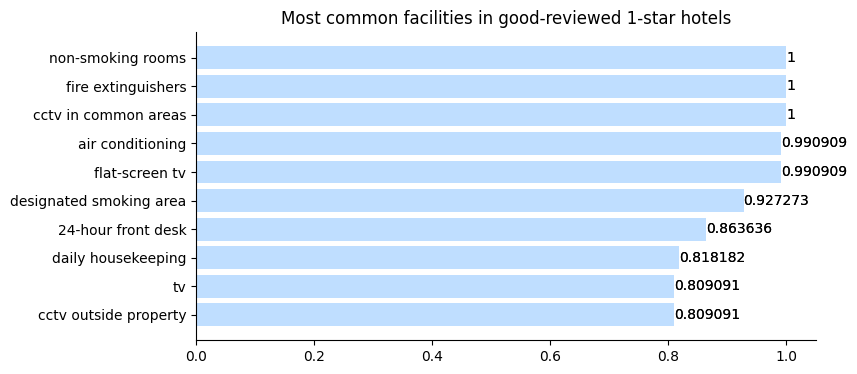

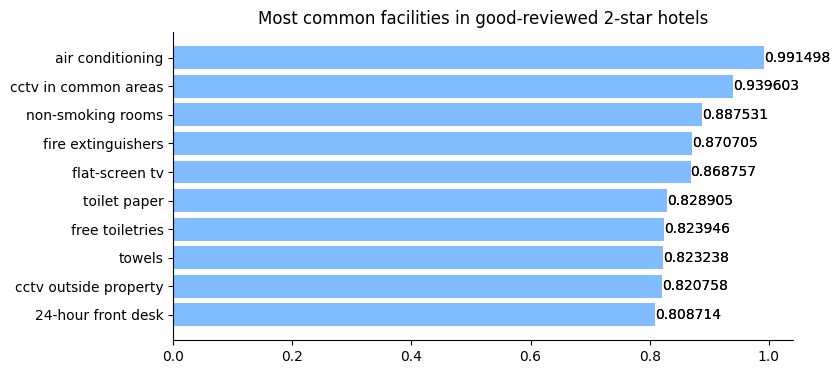

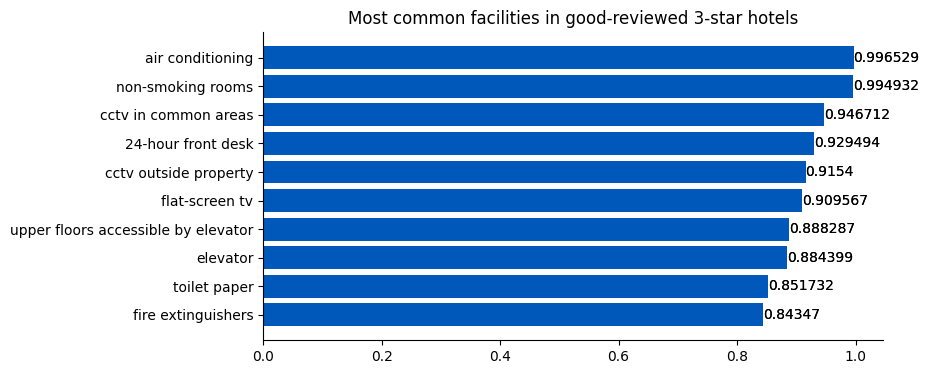

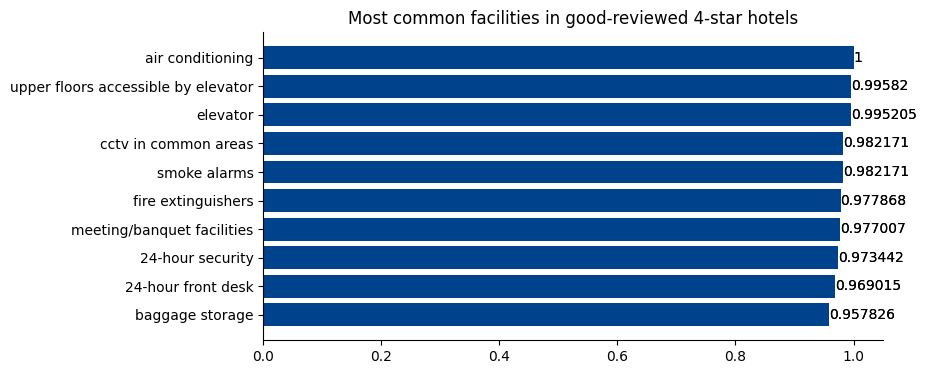

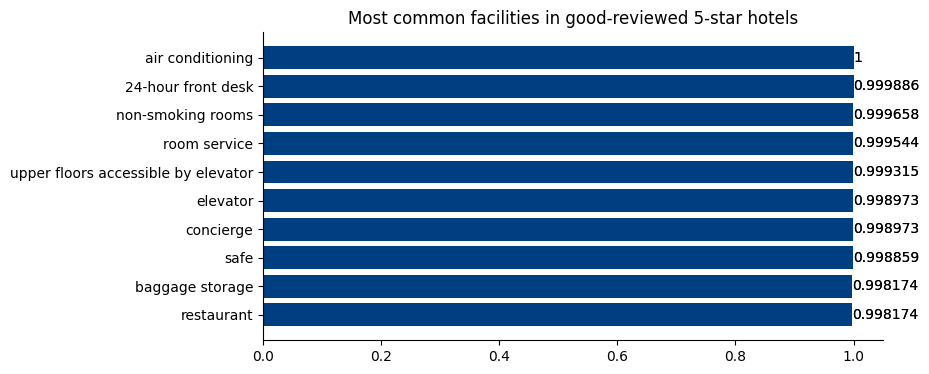

In [178]:
for i in range(5):
    most_facs_per_star(i+1)
    

In [185]:
### Star = 1-5
def least_facs_per_star(star):
    colors = ['#bfdeff', '#80bcff', '#0059ba', '#00438c', '#003e82']
    dfs = df_fac[(df_fac['stars'] == star) & (df_fac['good_review'] == 0)]
    total_cols = dfs.shape[0]
    dfs = dfs.set_index('hotel_name_')
    to_drop = ['facilities_count','stars', 'review_rating', 'total_reviews', 'good_review', 'top50_facs']
    dfs_trans = dfs.drop(to_drop, axis=1)
    dfs_trans = dfs_trans.T
    dfs_trans['freq_of_facilities'] = dfs_trans.sum(axis = 1)
    dfs_trans['\% of freq_of_facilities'] = dfs_trans['freq_of_facilities'] / total_cols
    dfs_trans.sort_values(by=['\% of freq_of_facilities'], inplace=True)
    
    
    colors_l = [colors[star-1]] * 20
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(dfs_trans.index[:10], dfs_trans['\% of freq_of_facilities'].iloc[:10], color=colors_l)
    ax.set_title(f'Lacking facilities in bad-reviewed {star}-star hotels')
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
        ax.bar_label(ax.containers[0])
    plt.show()

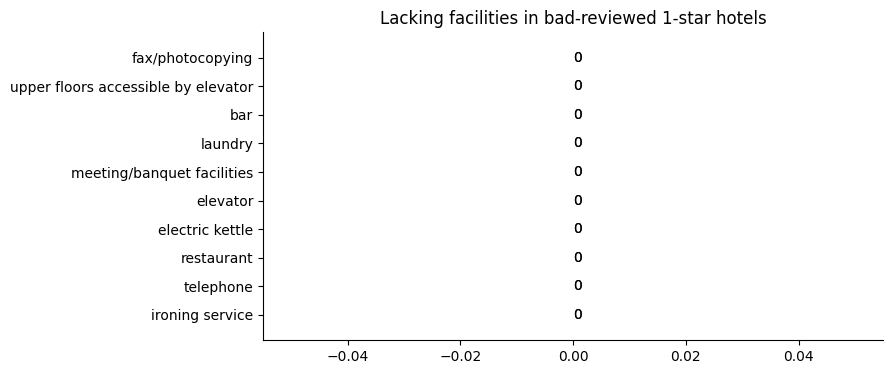

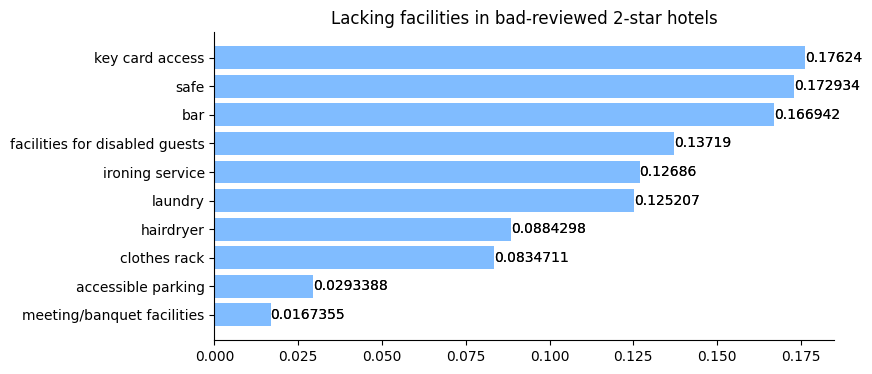

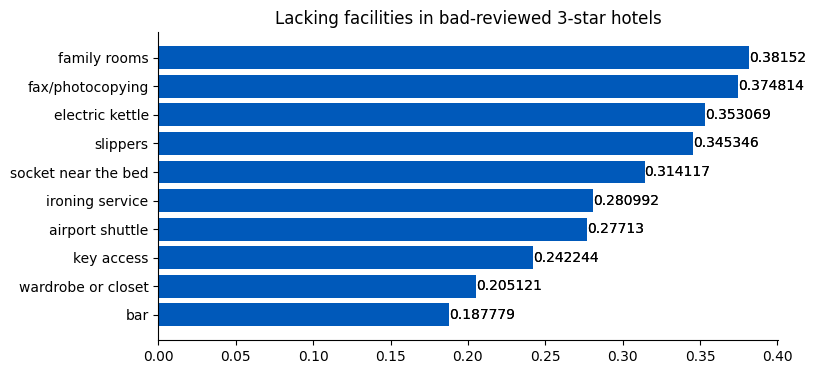

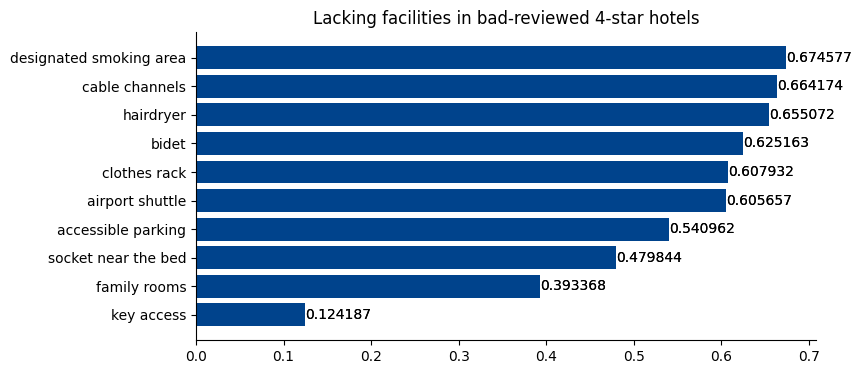

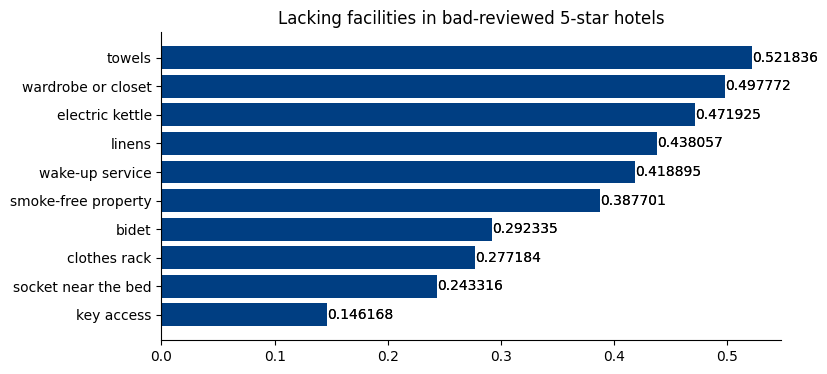

In [186]:
for i in range(5):
    least_facs_per_star(i+1)

### LogReg, to do model explainability

##### Model explainability will test which facilities are an influencer in a good review (vs a bad review)

In [44]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [47]:
df_ml = df_fac.drop(['hotel_name_', 'stars', 'total_reviews', 'review_rating', 'facilities_count', 'top50_facs'], axis=1)
df_ml

,good_review,air conditioning,non-smoking rooms,fire extinguishers,cctv in common areas,private bathroom,smoke alarms,toilet,tv,24-hour security,...,hairdryer,slippers,key access,accessible parking,facilities for disabled guests,wardrobe or closet,clothes rack,socket near the bed,bar,ironing service
0,1,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,1,1,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76531,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76532,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76533,0,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0
76534,0,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,0,0


In [48]:
X = df_ml.drop(['good_review'], axis=1)
y = df_ml['good_review']

In [55]:
(X_train, X_test, y_train, y_test) = train_test_split(
    X,  # input data
    y,  # target
    random_state=1337,  # for reproducability
    test_size=0.25)

In [56]:
lr = LogisticRegression(random_state=1337) # build the model
lr.fit(X_train, y_train)

print('Train Accuracy', lr.score(X_train, y_train)) # training set accuracy
print('Test Accuracy', lr.score(X_test, y_test)) # test set accuracy

Train Accuracy 0.6823107208808056
Test Accuracy 0.6885125953799519


In [51]:
# hypertune using different random state and parameter values
df_training = pd.DataFrame()
df_test = pd.DataFrame()

for seedN in tqdm(range(1, 11)):
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=seedN, test_size=0.25)
    
    test_accuracy = []
    training_accuracy = []
    alpha_run = [1e-8, 1e-5, 1e-3, 0.1, 0.2, 0.4, 0.75, 1]
    
    for alpha in tqdm(alpha_run):
    
        lr = LogisticRegression(C=alpha, max_iter=100000) 
        lr.fit(X_train, y_train)
    
        training_accuracy.append(lr.score(X_train, y_train))
        test_accuracy.append(lr.score(X_test, y_test))
        
    df_training[seedN] = training_accuracy
    df_test[seedN] = test_accuracy

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
df_accuracy = pd.DataFrame({'C': alpha_run,
                           'Training Accuracy': df_training.mean(axis=1),
                           'Test Accuracy': df_test.mean(axis=1)})
df_accuracy

,C,Training Accuracy,Test Accuracy
0,1.000000e-08,0.672292,0.672525
1,1.000000e-05,0.672292,0.672525
2,1.000000e-03,0.680422,0.680955
3,1.000000e-01,0.684319,0.684765
4,2.000000e-01,0.684347,0.684640
5,4.000000e-01,0.684187,0.684582
6,7.500000e-01,0.684269,0.684739
7,1.000000e+00,0.684269,0.684739


In [58]:
X = df_ml.drop(['good_review'], axis=1)
y = df_ml['good_review']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=1337, test_size=0.25,
                                                                  stratify=y)

In [59]:
model =  LogisticRegression(random_state=1337)
model = model.fit(X_trainval, y_trainval)

In [64]:
from sklearn.metrics import precision_score, recall_score, make_scorer
import shap

In [62]:
y_preds = model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Holdout set score: 0.94


In [80]:
model.predict_proba(X)

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [72]:
masker = shap.maskers.Independent(data = X_test)

In [73]:
explainer = shap.explainers.Linear(model, masker,feature_names=X_holdout.columns)
shap_values = explainer.shap_values(X_holdout)

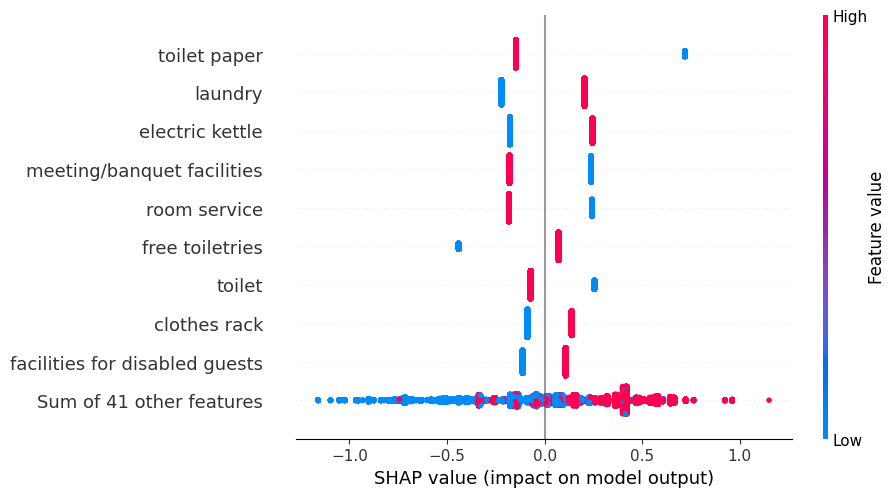

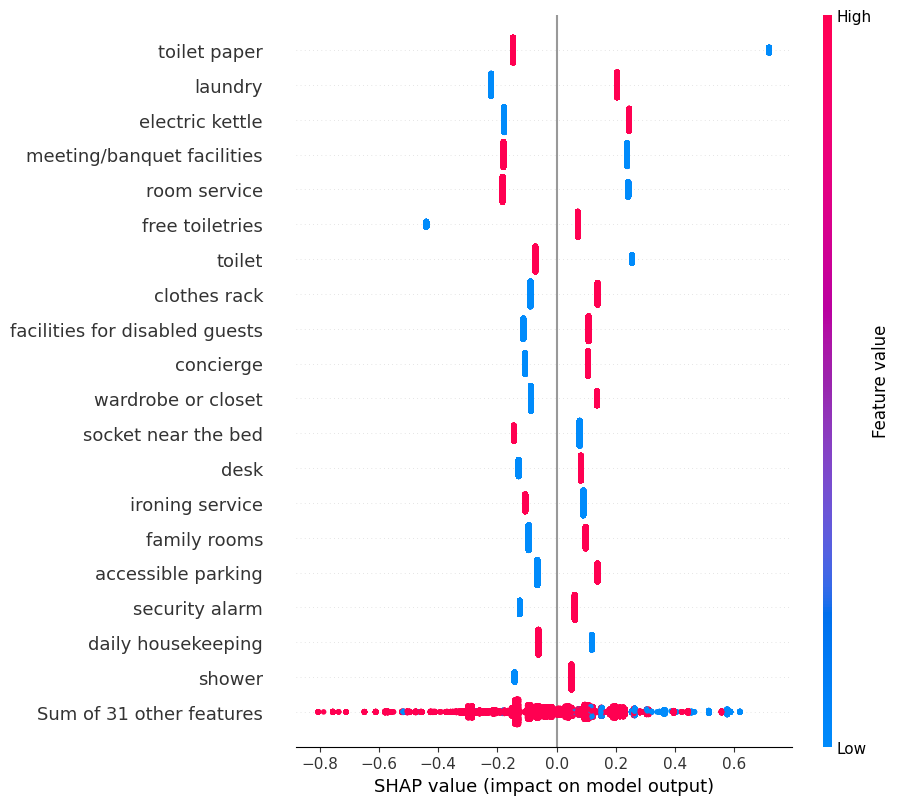

In [76]:
explainer = shap.Explainer(model, X_holdout)
shap_values = explainer(X_holdout)
shap.plots.beeswarm(shap_values)
shap.plots.beeswarm(shap_values, max_display=20)

In [77]:
predict_log_proba(X)[source]

NameError: name 'predict_log_proba' is not defined